- [CNN](https://github.com/rickiepark/pytorch-examples/blob/master/mnist.ipynb)
- [Logit Normalization](https://github.com/hongxin001/logitnorm_ood)

In [1]:
%pylab
%matplotlib inline
%load_ext watermark
%watermark -v -p numpy,torch,sklearn

Using matplotlib backend: <object object at 0x107f1f390>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy  : 1.26.2
torch  : 2.1.1
sklearn: 1.3.0



In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from loss_function import LogitNormLoss
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
def seed_everything(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything(2024)

In [4]:
def entropy(logits):
    full_probs = F.softmax(logits, dim=-1, dtype=torch.float32)
    full_logprobs = F.log_softmax(logits, dim=-1, dtype=torch.float32)
    ent = -torch.sum(full_probs * full_logprobs, dim=-1)
    return ent

In [5]:
class MnistClassifier(nn.Module):
    def __init__(self):
        super(MnistClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)   # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x) # F.log_softmax(x)

In [6]:
batch_size = 50
train_subset, val_subset, cal_subset, test_subset = torch.utils.data.random_split(
        datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()), [15000, 15000, 15000, 15000], generator=torch.Generator().manual_seed(1))

train_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size)

In [7]:
classifier = MnistClassifier()
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
classifier.train()
train_loss = []
train_accu = []
i = 0
loss_func = LogitNormLoss('cpu', 0.1)
for epoch in range(5):
    for data, target in train_loader:
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = classifier(data)
        loss = loss_func(output, target) # F.nll_loss(output, target)
        loss.backward()    # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()   # update gradients
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(target.data).sum()/batch_size*100
        train_accu.append(accuracy)
        if i % 100 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))
        i += 1
        
classifier.eval()

/var/folders/x8/908frjt170d_bfpfjzgp163r0000gn/T/ipykernel_55523/4031152407.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x) # F.log_softmax(x)


Train Step: 0	Loss: 2.327	Accuracy: 6.000
Train Step: 100	Loss: 0.385	Accuracy: 92.000
Train Step: 200	Loss: 0.212	Accuracy: 92.000
Train Step: 300	Loss: 0.108	Accuracy: 98.000
Train Step: 400	Loss: 0.153	Accuracy: 96.000
Train Step: 500	Loss: 0.242	Accuracy: 92.000
Train Step: 600	Loss: 0.040	Accuracy: 100.000
Train Step: 700	Loss: 0.075	Accuracy: 96.000
Train Step: 800	Loss: 0.046	Accuracy: 100.000
Train Step: 900	Loss: 0.157	Accuracy: 98.000
Train Step: 1000	Loss: 0.045	Accuracy: 98.000
Train Step: 1100	Loss: 0.028	Accuracy: 100.000
Train Step: 1200	Loss: 0.201	Accuracy: 94.000
Train Step: 1300	Loss: 0.073	Accuracy: 98.000
Train Step: 1400	Loss: 0.039	Accuracy: 98.000


MnistClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [8]:
cal_loader = torch.utils.data.DataLoader(dataset=cal_subset, shuffle=False, batch_size=len(cal_subset.indices))
for data, target in cal_loader:
    data, target = Variable(data), Variable(target)
    output = classifier(data)
# AcalPredict = regressor(data).detach().numpy().flatten()
Acal = 1 - output[np.arange(output.shape[0]), target]
# Acal = entropy(output)
Acal = Acal.detach().numpy()

Bcal = Acal / entropy(output).detach().numpy()

/var/folders/x8/908frjt170d_bfpfjzgp163r0000gn/T/ipykernel_55523/4031152407.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x) # F.log_softmax(x)


QA, QB 0.81761885 0.3554769


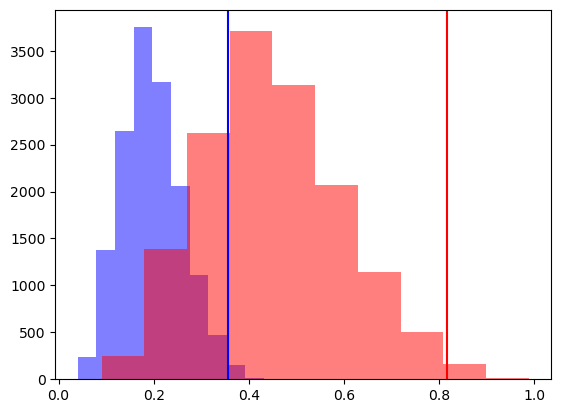

In [10]:
plt.hist(Bcal, alpha=.5, color='b', label='reweighted')
plt.hist(Acal, alpha=.5, color='r', label='original')
alpha = .01
QB = np.sort(Bcal)[int(np.ceil((len(Bcal) + 1) * (1 - alpha)))]
QA = np.sort(Acal)[int(np.ceil((len(Acal) + 1) * (1 - alpha)))]
print("QA, QB", QA, QB)
plt.axvline(x=QB, color='b')
plt.axvline(x=QA, color='r')

/var/folders/x8/908frjt170d_bfpfjzgp163r0000gn/T/ipykernel_55523/4031152407.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x) # F.log_softmax(x)


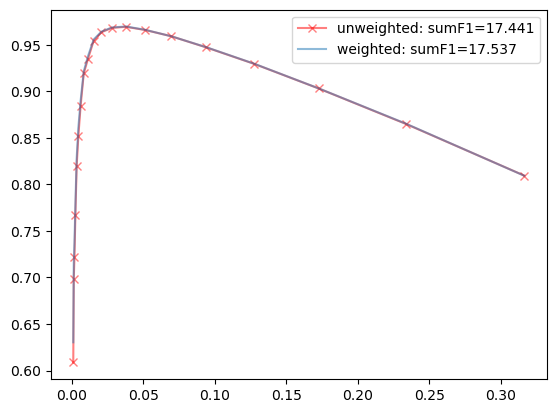

In [14]:
fig, ax = plt.subplots()

gamma = 0.0
tryAlpha = np.logspace(-3, -0.5, 20)
test_loader = torch.utils.data.DataLoader(dataset=test_subset, shuffle=False, batch_size=len(test_subset.indices))
for data, target in test_loader:
    data, target = Variable(data), Variable(target)
    output = classifier(data)

probsTest = output.detach().numpy()
y_test = target.detach().numpy()
Atest = np.array([[1 - probsTest[i][j] for j in range(len(probsTest[i]))] for i in range(len(probsTest))])
Btest = Atest / (entropy(output).detach().numpy()[:, np.newaxis])

auc = [], []
# Bcal = Acal / (AcalPredict + gamma)
# Btest = Atest / (AtestPredict[:, np.newaxis] + gamma)

for alpha in tryAlpha:
    QA = np.sort(Acal)[int(np.ceil((len(Acal) + 1) * (1 - alpha)))-1]
    QB = np.sort(Bcal)[int(np.ceil((len(Bcal) + 1) * (1 - alpha)))-1]

    intervalsA = [[j for j in range(len(probsTest[i])) if Atest[i][j] <= QA] for i in range(len(probsTest))]
    intervalsB = [[j for j in range(len(probsTest[i])) if Btest[i][j] <= QB] for i in range(len(probsTest))]

    TP, FP, TN, FN = [0, 0], [0, 0],[0, 0], [0, 0]
    intervalsAll = intervalsA, intervalsB
    for iModel in [0, 1]:
        for i in range(len(intervalsA)):
            intervals = intervalsAll[iModel][i]
            y = y_test[i]
            positives = [j for j in range(10) if j in intervals]
            TP[iModel] = TP[iModel] + sum([1 for j in positives if j == y])
            FP[iModel] = FP[iModel] + sum([1 for j in positives if j != y])
            negatives = [j for j in range(10) if j not in intervals]
            TN[iModel] = TN[iModel] + sum([1 for j in negatives if j != y])  
            FN[iModel] = FN[iModel] + sum([1 for j in negatives if j == y]) 
        F1 = 2 * TP[iModel]/(2 * TP[iModel] + FP[iModel] + FN[iModel])
        auc[iModel].append(F1)
s = [np.round(sum([x for x in auc[iModel]]), 3) for iModel in [0, 1]]
ax.plot(tryAlpha, [x for x in auc[0]], label='unweighted: sumF1='+str(s[0]), alpha=0.5, color='r', marker='x')
ax.plot(tryAlpha, [x for x in auc[1]], label=f'weighted: sumF1='+str(s[1]), alpha=0.5)
  
plt.legend()


In [15]:
from collections import Counter
Counter([len(a) for a in intervalsA]), Counter([len(a) for a in intervalsB])

(Counter({1: 10206, 0: 4794}), Counter({1: 10203, 0: 4797}))

In [16]:
(np.array(auc[0]) - np.array(auc[1]))

array([-2.17093209e-02, -1.78845332e-02, -1.53520769e-02, -1.03309589e-02,
       -8.04335580e-03, -9.11895620e-03, -5.39799280e-03, -2.13092189e-03,
       -2.83423045e-03, -1.35281692e-03, -6.97996610e-04, -3.84267393e-04,
       -3.97021499e-04, -2.27318193e-04,  2.81205005e-06, -2.16700376e-04,
       -1.52321248e-04, -1.20127317e-04, -3.00412750e-04,  1.41710534e-04])